# Course Project: Wildfire Analysis (Part 1: Common Analysis)

## Create Fire Smoke Estimates

More and more frequently summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread as wildfire smoke reduces the air quality of many cities. There is a growing body of work pointing to the negative impacts of smoke on health, tourism, property, and other aspects of society.

The Course Project is designed to analyze the impacts of wildfires on specific cities in the United States, particularly focusing on the effects of wildfire smoke and its implications for public health, air quality, and overall community well-being.

This is the first step in the project, where all the students conduct a base analysis using a shared dataset while focusing on a unique city. The aim is to create an understanding of wildfire impacts tailored to local contexts.

​This notebook analyzes the impact of wildfire smoke on Vancouver, WA, focusing on data from the last 60 years.​ We begin by loading the wildfire dataset (extracted in the previous step) while filtering for fires that occurred during the fire season (May to October). Through exploratory data analysis, we define a smoke estimate based on fire size, type, and distance from the city, subsequently calculating and scaling these estimates. We finally aggregate and visualize yearly wildfire occurrences and smoke estimates and save the generated dataset for further reference.


## 1. Import libraries and required dependencies

In [10]:
# !pip install scipy

In [76]:
# import numpy to aid in numerical computing
import numpy as np

# import pandas - we will have the valid attributes finally as a csv
import pandas as pd

# import a few libraries to create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For better readability, I clear the cell output when running code in batches
from IPython.display import clear_output

# Many relationships here are non-linear, cannot compute pearson correlation actor for the same.
# using spearman correlation in such cases.
from scipy.stats import spearmanr

# suppress the warnings
import warnings
warnings.filterwarnings("ignore")

I have been assigned to analyse the city: Vancouver, WA for my analysis
- 2023 estimate: 196442
- 2020 census: 190915
- 2020 density: 3920
- Latitude/Longitude: 45.64°N 122.60°W

In [77]:
# CONSTANTS
DATA_FILENAME = "../data/intermediate_data/wildfire_dataset_with_distance.csv"
#
# print out where we think we're going to find the sample data
print(f"{DATA_FILENAME=}")

# A dictionary of the city location from the US west coast state.
CITY_LOCATIONS = {
    'vancouver' :   {'city'   : 'Vancouver',
                    'latlon' : [45.64, -122.60] }
}

DATA_FILENAME='../data/intermediate_data/wildfire_dataset_with_distance.csv'


## 2. Developing the Smoke Estimate

The common research question that we are to answer is:
- **What are the estimated wildfire smoke impacts on your assigned city each year for the most recent 60 years of wildfire data?** We have to create an annual estimate of wildfire smoke in your assigned city. This estimate is just a number that we can eventually use to build a predictive model. Technically, smoke impact should probably be considered the health, tourism, economic or other social problems that result from the smoke. We will consider other potential social and economic impacts during Part 2 of the course project. 

For now, we need some kind of number to represent an estimate of the smoke your city saw during each annual fire season.
- **Why is this an estimate of fire smoke?** These are estimates because of a number of problems that are not easy to resolve combined with simplifications to make this course project reasonable for just a few weeks of work. One example is that an actual smoke impact would be based on wind direction over a course of several days, the intensity of the fire, and its duration. However, the fire polygon data only (reliably) provide a year for each fire - it does not (reliably) provide specific start and end dates for the fire. 

The smoke estimate should adhere to the following conditions:
- The estimate only considers the last 60 years of wildland fire data (1961-2021).
    - We have handled this in the first step.
- The estimate only considers fires that are within 650 miles of your assigned city.
    - We will handle this in the later part of this notebook.
- Defines the annual fire season as running from May 1st through October 31st.
    - We need to check this here, 

It seems reasonable that a large fire, that burns a large number of acres, and that is close to a city would put more smoke into a city than a small fire that is much further away. One task is to define the smoke estimate and then apply it to every fire within the specified distance to your city.

### 2.1 Load the Wildfire dataset generated in the previous step


In [79]:
wildfire_df_raw = pd.read_csv("../data/intermediate_data/wildfire_dataset_with_distance.csv")
wildfire_df_raw.drop(columns=["Unnamed: 0"], inplace=True)
print(wildfire_df_raw.shape)
wildfire_df_raw.head()

(280268, 31)


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,average_distance
0,13526,13526,Wildfire,1961.0,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.398775,NaN,No,83939.248629,2.235878e+08,369.362521
1,13527,13527,Wildfire,1961.0,1,"1 (4), 3 (6)",43920.841077,17774.133779,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,"Caution, this Wildfire in 1961 overlaps with a...",0.304477,NaN,No,85648.862830,1.777413e+08,596.735456
2,13528,13528,Wildfire,1961.0,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.320032,NaN,No,73755.413582,1.385389e+08,505.921210
3,13529,13529,Wildfire,1961.0,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.481665,NaN,No,58906.755757,1.330042e+08,584.054693
4,13530,13530,Wildfire,1961.0,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.433246,NaN,No,56575.916692,1.103539e+08,166.864775


Before having the smoke estimate, let us performn some exploratory data analysis to understand the data better.
### 2.2 Exploratory Data Analysis

In [14]:
wildfire_df_raw.describe()

,OBJECTID,USGS_Assigned_ID,Fire_Year,Fire_Polygon_Tier,GIS_Acres,GIS_Hectares,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,average_distance
count,46796.000000,46796.000000,46796.000000,46796.000000,4.679600e+04,46796.000000,46796.000000,4904.0,4.679600e+04,4.679600e+04,46796.000000
mean,71058.447624,71058.447624,1999.049705,3.142576,1.839001e+03,744.217117,0.499262,1.0,9.555675e+03,7.442171e+06,361.904414
std,39915.479321,39915.479321,15.444107,2.960309,1.467352e+04,5938.162489,0.268347,0.0,3.393214e+04,5.938162e+07,155.591708
min,13526.000000,13526.000000,1961.000000,1.000000,4.697010e-06,0.000002,0.000051,1.0,6.295036e-01,1.900813e-02,5.264362
25%,35932.750000,35932.750000,1987.000000,1.000000,1.524816e+01,6.170711,0.284043,1.0,1.220261e+03,6.170711e+04,233.765734
50%,62451.500000,62451.500000,2002.000000,1.000000,6.969532e+01,28.204696,0.465300,1.0,3.042503e+03,2.820470e+05,367.836960
75%,111034.750000,111034.750000,2012.000000,7.000000,4.066718e+02,164.574256,0.681704,1.0,7.940103e+03,1.645743e+06,491.012529
max,135061.000000,135061.000000,2020.000000,8.000000,1.032651e+06,417899.203637,0.997980,1.0,2.899586e+06,4.178992e+09,649.971984


We have data between the years 1965 - 2020 as mentioned in the assignment.

We are asked to only consider wildfires between May - October, Let us filter out the other instances.

In [80]:
# For simplicity: 
#   get the first date that matches the YYYY-MM-DD format from each entry in the Listed_Fire_Dates column.
wildfire_df_raw['First_Listed_Fire_Dates'] = wildfire_df_raw['Listed_Fire_Dates'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]

# obtain the month from date
wildfire_df_raw['First_Listed_Fire_Dates'] = pd.to_datetime(wildfire_df_raw['First_Listed_Fire_Dates'])
wildfire_df_raw['First_Listed_Fire_Month'] = wildfire_df_raw['First_Listed_Fire_Dates'].dt.month

# Filter to have data between the months of May - October
wildfire_df = wildfire_df_raw[(wildfire_df_raw["First_Listed_Fire_Month"] >= 5.0) & 
                              (wildfire_df_raw["First_Listed_Fire_Month"] <= 10.0)]

print(wildfire_df.shape)
wildfire_df.head()

(68394, 33)


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,average_distance,First_Listed_Fire_Dates,First_Listed_Fire_Month
0,13526,13526,Wildfire,1961.0,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,NaN,NaN,0.398775,NaN,No,83939.248629,2.235878e+08,369.362521,1961-09-08,9.0
1,13527,13527,Wildfire,1961.0,1,"1 (4), 3 (6)",43920.841077,17774.133779,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,NaN,"Caution, this Wildfire in 1961 overlaps with a...",0.304477,NaN,No,85648.862830,1.777413e+08,596.735456,1961-07-10,7.0
2,13528,13528,Wildfire,1961.0,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,NaN,NaN,0.320032,NaN,No,73755.413582,1.385389e+08,505.921210,1961-09-02,9.0
3,13529,13529,Wildfire,1961.0,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,NaN,NaN,0.481665,NaN,No,58906.755757,1.330042e+08,584.054693,1961-07-12,7.0
4,13530,13530,Wildfire,1961.0,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,NaN,NaN,0.433246,NaN,No,56575.916692,1.103539e+08,166.864775,1961-09-01,9.0


In [81]:
wildfire_df.to_csv("../data/intermediate_data/wildfire_dataset_with_distance_cutoff.csv", index=False)

wildfire_df = wildfire_df[wildfire_df['average_distance'] <= 650]

wildfire_df['average_distance'].describe()

count    34705.000000
mean       378.109596
std        155.974564
min          5.264362
25%        258.716030
50%        389.165206
75%        515.192821
max        649.971984
Name: average_distance, dtype: float64

We have the maximum distance as 650 miles.

According to this statement provided by the professor in the assignment "It seems reasonable that a large fire, that burns a large number of acres, and that is close to a city would put more smoke into a city than a small fire that is much further away.", smoke factor can be based on:
- `average_distance`
- `GIS_Acres` or `GIS_Hectares` or `Shape_Area` or `Shape_Length` (all are correlated, let us go ahead with `GIS_Acres` in this project)

I am also interested to see if `Assigned_Fire_Type` and `Listed_Fire_Cause_Class` has anything to contribute.

First let us see the values in the column `Assigned_Fire_Type`:

In [16]:
wildfire_df["Assigned_Fire_Type"].unique().tolist()

['Wildfire',
 'Unknown - Likely Wildfire',
 'Prescribed Fire',
 'Likely Wildfire',
 'Unknown - Likely Prescribed Fire']

We have a clear set of Fire Types. Different fire types, like wildfires and prescribed fires, affect air quality and the environment in different ways [(reference)](https://extension.oregonstate.edu/catalog/pub/em-9203-fire-faqs-air-quality-impacts-prescribed-fire-wildfire-how-do-they-compare#:~:text=As%20smoke%20emissions%20increase%2C%20the,and%20typically%20are%20much%20larger.). By giving each type a specific weight, I can understand their different impact levels. For example, wildfires have a higher weight of 1.0, while prescribed fires, which are controlled, have a lower weight of 0.5. Other types, like “Likely Wildfire” and “Unknown - Likely Wildfire,” are given weights of 0.7 and 0.8, respectively, based on their potential intensity. "Unknown - Likely Prescribed Fire" is given even more smaller weight of 0.3. 

In [17]:
assigned_fire_type_mapping = {
    'Wildfire': 1.0,
    'Unknown - Likely Wildfire': 0.8,
    'Prescribed Fire': 0.5,
    'Likely Wildfire': 0.7,
    'Unknown - Likely Prescribed Fire': 0.3
}

# Add a new label column
wildfire_df['Assigned_Fire_Type_Label'] = wildfire_df['Assigned_Fire_Type'].map(assigned_fire_type_mapping)
wildfire_df["Assigned_Fire_Type_Label"].unique().tolist()

[1.0, 0.8, 0.5, 0.7, 0.3]

Now let us observe the `Listed_Fire_Cause_Class` column.

In [18]:
# wildfire_df["Listed_Fire_Cause_Class"].unique()

There are a lot of irrelevant information here, we will first clean the column.

In [19]:
wildfire_df["Listed_Fire_Cause_Class_cleaned"] = (
    wildfire_df["Listed_Fire_Cause_Class"]
    .str.replace(r'[^a-zA-Z\s]', '', regex=True) # keep only letters and spaces
    .str.strip() # remove leading and trailing spaces/tabs
    .str.split()  # split by spaces to get the words
    .str[0]  # get the first word
)

wildfire_df["Listed_Fire_Cause_Class_cleaned"].unique().tolist()

['Undetermined', 'Human', 'Natural']

Just to see if the cause is associated with any other variable, let us manually label for now.

In [20]:
fire_cause_class_mapping = {
    'Undetermined': 0,
    'Human': 1, 
    'Natural':2
}

# Add a new label column
wildfire_df['Listed_Fire_Cause_Class_cleaned_Label'] = wildfire_df['Listed_Fire_Cause_Class_cleaned'].map(fire_cause_class_mapping)
wildfire_df["Listed_Fire_Cause_Class_cleaned_Label"].unique().tolist()

[0, 1, 2]

Let us try to see if there are any trends between variables

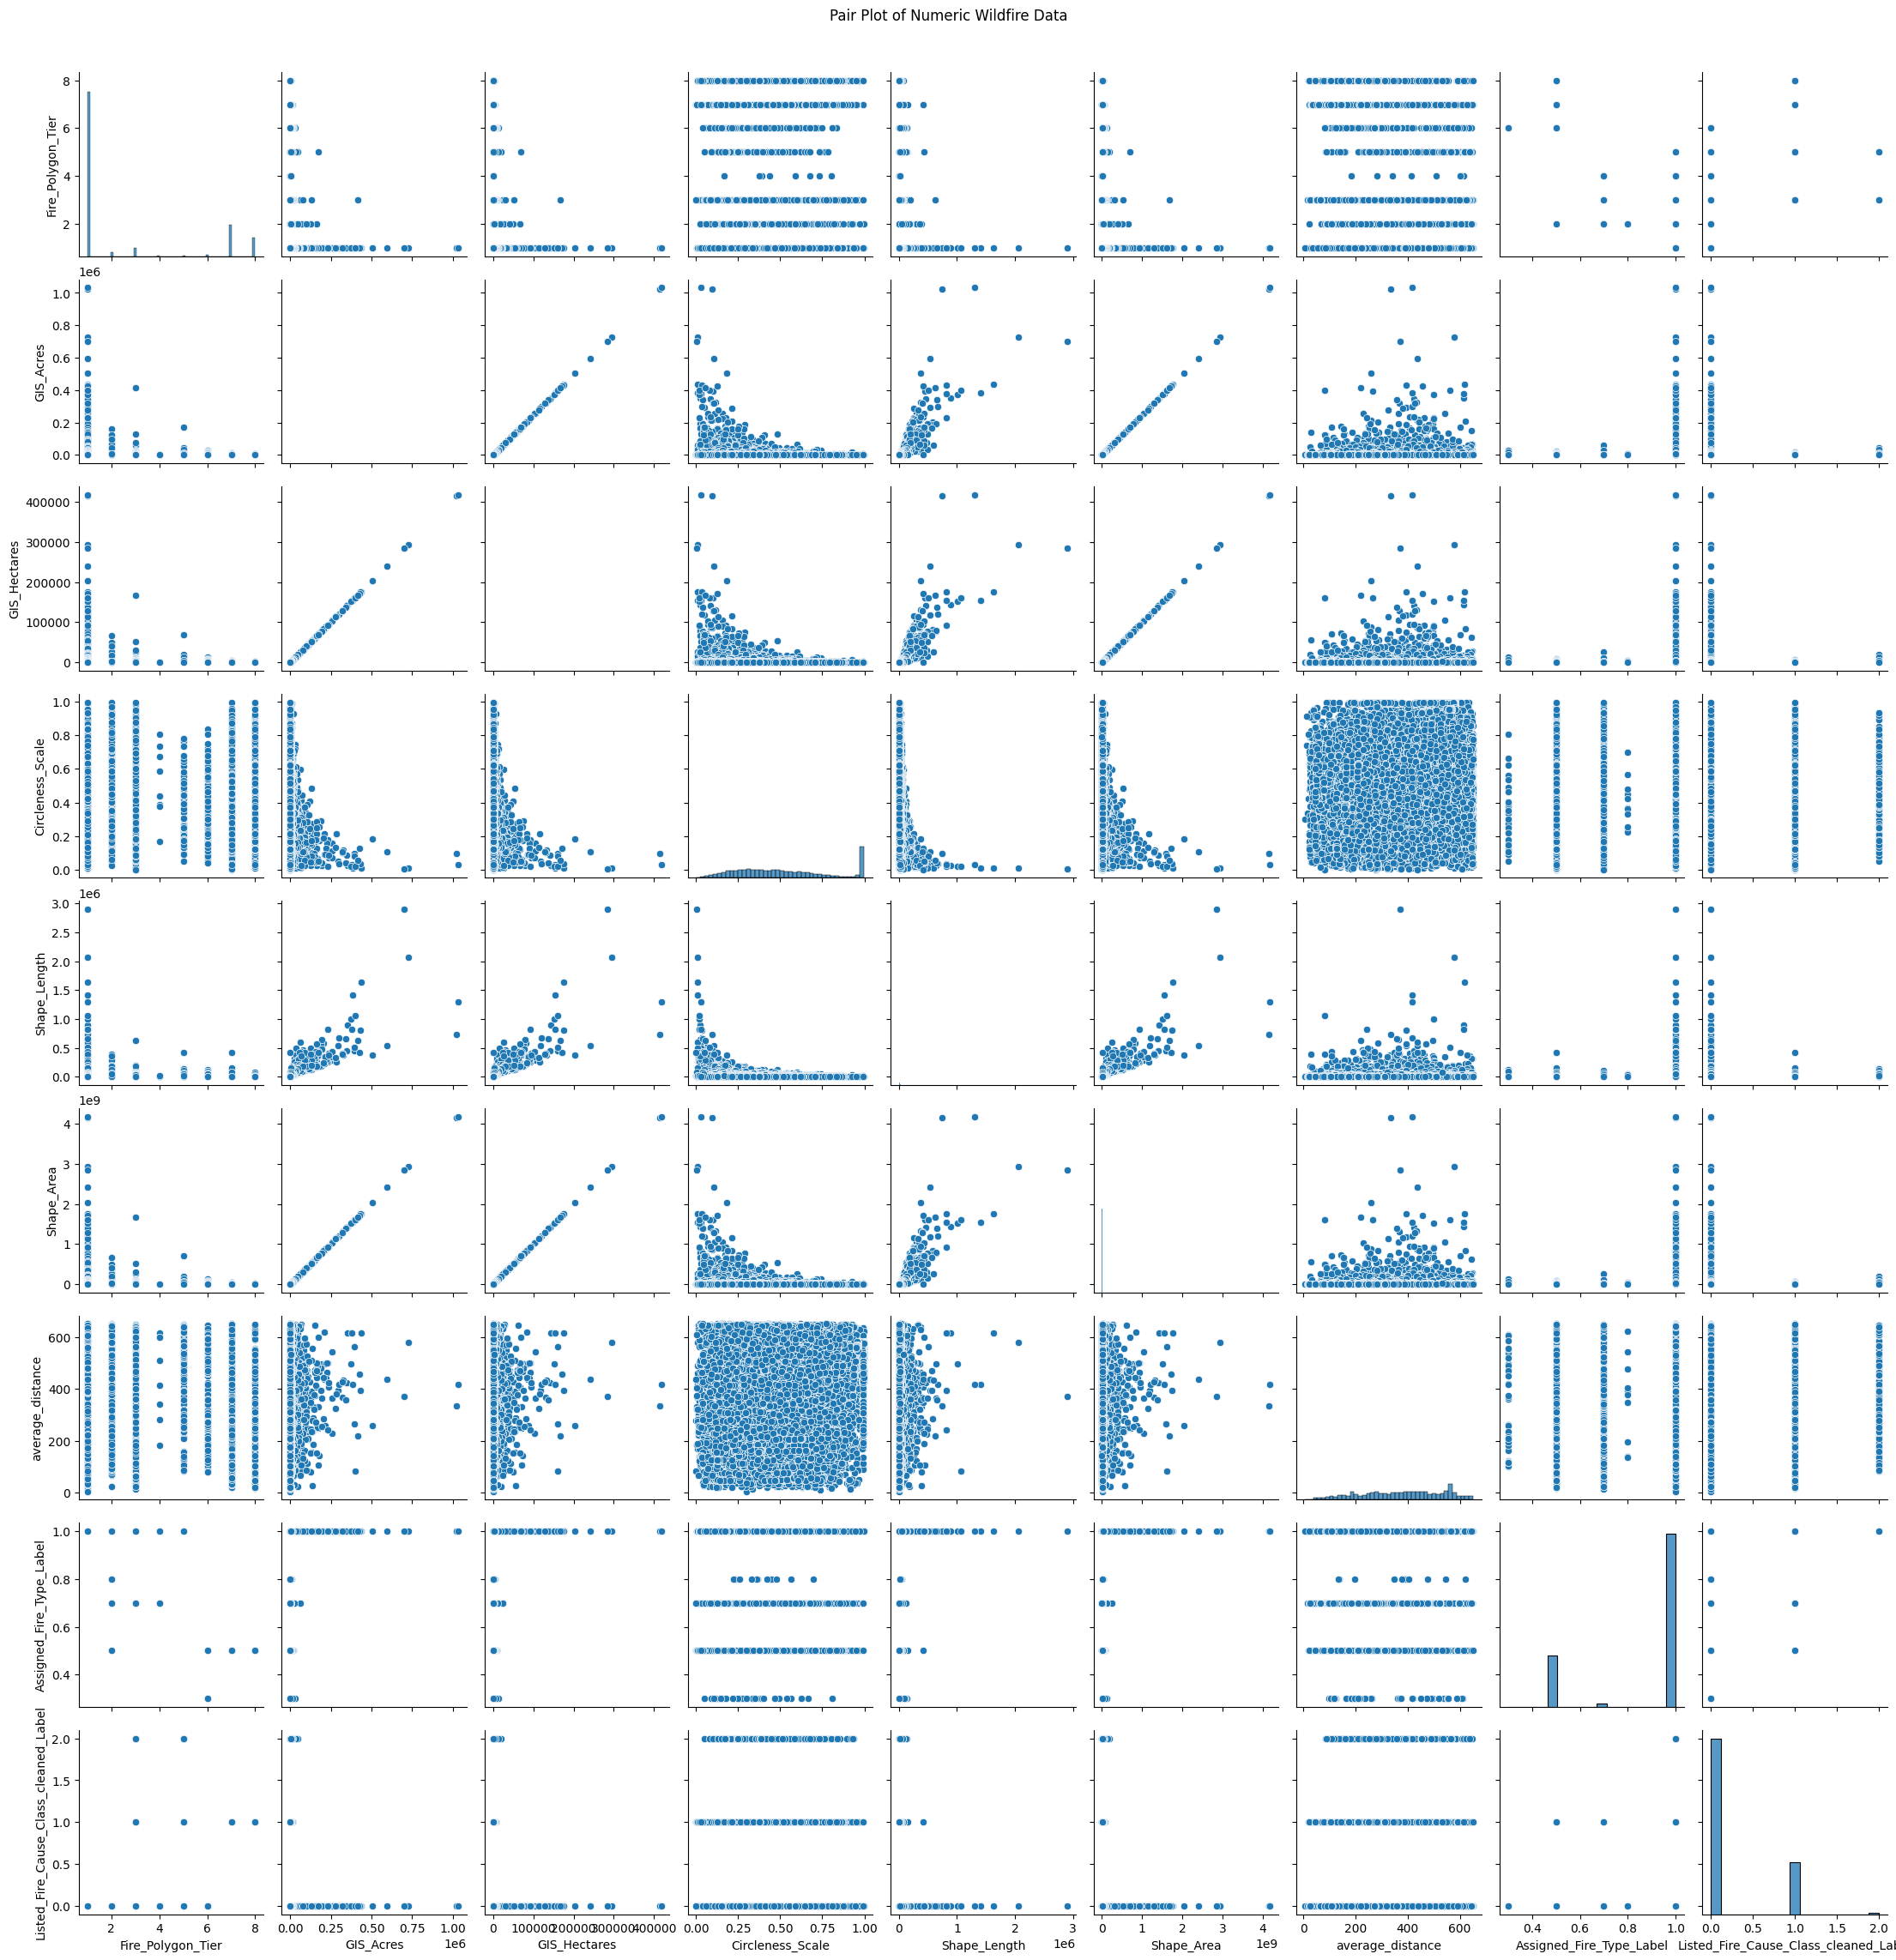

In [21]:
numeric_wildfire_df = wildfire_df.select_dtypes(include='number')
numeric_wildfire_df.drop(columns=["Circle_Flag", "Fire_Year", "First_Listed_Fire_Month", "OBJECTID", "USGS_Assigned_ID"], inplace=True)

sns.pairplot(numeric_wildfire_df)
plt.suptitle('Pair Plot of Numeric Wildfire Data', y=1.02)
plt.show()

It looks like many variables have non-linear trends with each other. We cannot compute the Pearson correlation in this case. Let us have the Spearman correlation. 

Let us now plot the heatmap to see if the variables are correlated.

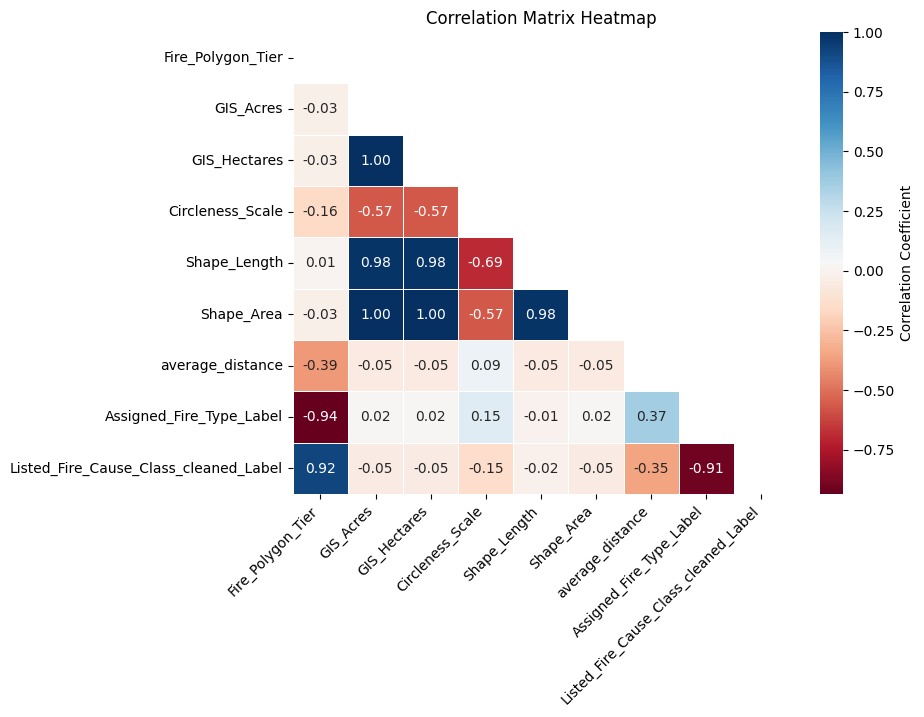

In [22]:
# Get the correlation matrix (spearman)
correlation_matrix = numeric_wildfire_df.corr(method='spearman')

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap='RdBu',
    annot=True,    
    fmt=".2f",        
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

To get a better understanding of what each field means, refer to the [Metadata](https://www.sciencebase.gov/catalog/file/get/61aa537dd34eb622f699df81?f=__disk__d0/63/53/d063532049be8e1bc83d1d3047b4df1a5cb56f15&transform=1&allowOpen=true#Data%20Quality%20Information).
- The `Circleness_Scale` was calculated by using the following equation `"4*pi*(Shape_Area/(Shape_Length * Shape_Length))"`. Probably that is a reason why the fields are even a bit related.
- The `Listed_Fire_Cause_Class_cleaned_Label` seems to be highly negatively correlated with `Assigned_Fire_Type_Label`. Since `Assigned_Fire_Type_Label` can be related to smoke estimation, let us ignore `Listed_Fire_Cause_Class_cleaned_Label` from further analysis.

Let us now check if there are any empty values in the columns of our interest.

In [23]:
# Check if any of the fields of my interest are empty
columns_to_check_null = ["Assigned_Fire_Type_Label", "GIS_Acres", "average_distance"]
empty_values =  wildfire_df[columns_to_check_null].isnull().sum() + wildfire_df[columns_to_check_null].isna().sum()

if empty_values.any():
    print("Empty values found in columns:\n")
    print(empty_values)
else:
    print("No missing values!")

No missing values!


There are no missing values!

As mentioned in [Metadata](https://www.sciencebase.gov/catalog/file/get/61aa537dd34eb622f699df81?f=__disk__d0/63/53/d063532049be8e1bc83d1d3047b4df1a5cb56f15&transform=1&allowOpen=true#Data%20Quality%20Information),polygons with near 100% overlap in consecutive years could be the same fire in different datasets with a year value that is correct in one and incorrect in another dataset. This can occur particularly with older fires. There is no way to identify the actual year or which one is correct, if one is in fact incorrect. Therefore, for any fires with >10% overlap within 1 -2 years of the focal fire, `Overlap_Within_1_or_2_Flag` flag is included.

There are two more reasons why the same field is included, though rare, a wildfire may intentionally be assigned as a prescribed fire. This occurs when a wildfire burns through a planned prescribed burn area. The other reason too, although rare, a wildfire burns through an area later in the same year after a prescribed fire occurs in the spring. 

It is often difficult or impossible to determine the true answer and so the fields are simply flagged to warn the users that the fire may not actually be it's assigned fire type. To avoid false positives, let us remove the rows where the field is flagged.

In [24]:
wildfire_df['Overlap_Within_1_or_2_Flag'].unique()

array([nan,
       'Caution, this Wildfire in 1961 overlaps with a Wildfire that occurred in 1959 (2 year difference). The overlapping fire overlaps by 17.0% (7481.0 acres). Overlapping fire USGS Assigned ID: 12587.',
       'Caution, this Wildfire in 1961 overlaps with a Wildfire that occurred in 1963 (2 year difference). The overlapping fire overlaps by 100.0% (1226.0 acres). Overlapping fire USGS Assigned ID: 14299.',
       ...,
       'Caution, this Prescribed Fire in 2020 overlaps with a Prescribed Fire that occurred in 2018 (2 year difference). The overlapping fire overlaps by 100.0% (20.0 acres). Overlapping fire USGS Assigned ID: 124961.',
       'Caution, this Prescribed Fire in 2020 overlaps with a Prescribed Fire that occurred in 2019 (1 year difference). The overlapping fire overlaps by 100.0% (7.0 acres). Overlapping fire USGS Assigned ID: 135002.',
       'Caution, this Prescribed Fire in 2020 overlaps with a Prescribed Fire that occurred in 2019 (1 year difference). The

In [25]:
# seems like we only want to keep the nan values 
wildfire_df = wildfire_df[wildfire_df['Overlap_Within_1_or_2_Flag'].isna()==True]

print(wildfire_df.shape)
wildfire_df.head()

(31892, 36)


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,average_distance,First_Listed_Fire_Dates,First_Listed_Fire_Month,Assigned_Fire_Type_Label,Listed_Fire_Cause_Class_cleaned,Listed_Fire_Cause_Class_cleaned_Label
0,13526,13526,Wildfire,1961,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,NaN,No,83939.248629,2.235878e+08,369.362521,1961-09-08,9.0,1.0,Undetermined,0
2,13528,13528,Wildfire,1961,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,NaN,No,73755.413582,1.385389e+08,505.921210,1961-09-02,9.0,1.0,Undetermined,0
3,13529,13529,Wildfire,1961,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,NaN,No,58906.755757,1.330042e+08,584.054693,1961-07-12,7.0,1.0,Undetermined,0
4,13530,13530,Wildfire,1961,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,NaN,No,56575.916692,1.103539e+08,166.864775,1961-09-01,9.0,1.0,Undetermined,0
7,13533,13533,Wildfire,1961,1,"1 (1), 3 (3)",13511.581889,5467.943194,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,NaN,No,40991.098726,5.467943e+07,384.339746,1961-07-24,7.0,1.0,Undetermined,0


Again, as mentioned in [Metadata](https://www.sciencebase.gov/catalog/file/get/61aa537dd34eb622f699df81?f=__disk__d0/63/53/d063532049be8e1bc83d1d3047b4df1a5cb56f15&transform=1&allowOpen=true#Data%20Quality%20Information), some of the fires in the wildfires dataset appear as near perfect circles. This could be from lightning strikes being counted as small fires or other small fires having a point buffered to the acreage of the fire size because no true polygon was created. A circle-ness index is thus calculated by using the following equation in field calculator,
```math
4 * pi * ( Shape Area / ( Shape Length * Shape Length ) )
```
As values of the circle-ness index approach 1, the shape becomes more circular. A 'Circle_Flag' column is thus present to flag any shapes with a value greater than or equal to 0.98.

Circular fire polygons are highly unlikely to represent the actual area burned. When fire size is less than 1 acre, the risk of misassigning the burned area is minimal given the fire size. 
For any circular polygons greater than 1 acre, the risk of misassigning a burned area is too high and hence these are not included in my analysis. `Exclude_From_Summary_Rasters` has a flag: 'Yes' for fires that are circular and greater than 1 acre, and 'No' for non-circular fires and circular fires lesser than 1 acre. 

The rows that have this field flagged as 'Yes' is removed from the analysis.

In [26]:
wildfire_df = wildfire_df[wildfire_df['Exclude_From_Summary_Rasters']=='No']

print(wildfire_df.shape)
wildfire_df.head()

(30700, 36)


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,average_distance,First_Listed_Fire_Dates,First_Listed_Fire_Month,Assigned_Fire_Type_Label,Listed_Fire_Cause_Class_cleaned,Listed_Fire_Cause_Class_cleaned_Label
0,13526,13526,Wildfire,1961,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,NaN,No,83939.248629,2.235878e+08,369.362521,1961-09-08,9.0,1.0,Undetermined,0
2,13528,13528,Wildfire,1961,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,NaN,No,73755.413582,1.385389e+08,505.921210,1961-09-02,9.0,1.0,Undetermined,0
3,13529,13529,Wildfire,1961,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,NaN,No,58906.755757,1.330042e+08,584.054693,1961-07-12,7.0,1.0,Undetermined,0
4,13530,13530,Wildfire,1961,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,NaN,No,56575.916692,1.103539e+08,166.864775,1961-09-01,9.0,1.0,Undetermined,0
7,13533,13533,Wildfire,1961,1,"1 (1), 3 (3)",13511.581889,5467.943194,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,NaN,No,40991.098726,5.467943e+07,384.339746,1961-07-24,7.0,1.0,Undetermined,0


### 2.3 Define and compute the smoke estimate

- First, I want to define in what range I want my values to be. According to [the U.S. AQI is EPA’s index for reporting air quality](https://www.airnow.gov/aqi/aqi-basics/), the AQI index ranges from 0 to 301+, where 0 is Good quality air and 301+ is Hazardous air quality. As I have to compare my smoke estimate to the AQI information, I would like to consider a similar range here as well. I will do this in the later steps.

- As mentioned while defining `Assigned_Fire_Type_Label`, different types of fires impact air quality and the environment differently, which is important when estimating smoke emissions. Wildfires, which are uncontrolled and intense, release a lot of pollutants, so we give them a higher weight of 1.0 to show their strong impact on air quality. Prescribed burns, on the other hand, are planned fires used to clear out fuel and prevent bigger wildfires. They produce less smoke and can have positive effects, so we give them a lower weight of 0.5 to reflect their smaller impact. Other types, like “Likely Wildfire” and “Unknown - Likely Wildfire”, are given weights of 0.7 and 0.8, respectively, based on their potential intensity. "Unknown - Likely Prescribed Fire" is given even more smaller weight of 0.3. 

- The size of the fire, represented in `GIS_Acres` can be beneficial in estimating the smoke impact. Bigger fires usually create more smoke because they have more fuel and burn for longer periods [(reference)](https://www.fs.usda.gov/rm/pubs_series/int/gtr/int_gtr030.pdf). To make the analysis more easier and for better comparison in the next step, we convert the size from acres to square miles (`GIS_SqMiles`) using a conversion factor of 0.0015625 (1 square mile = 640 acres) [(reference)](https://www.unitconverters.net/area/square-miles-to-acres.htm). 

In [27]:
wildfire_df['GIS_SqMiles'] = wildfire_df['GIS_Acres'] * 0.0015625

As smoke rises and travels away from the fire, it spreads out and mixes with the clean air around it, which reduces its concentration. To better understand this effect, I have used `average_distance` in calculating my smoke estimate: divide the expected smoke impact by dividing it by the average distance from the fire. This means that the closer a location is to the fire, the higher the smoke concentration will be, while areas farther away will experience less smoke. 

To craft the formula, I want to understand how `GIS_SqMiles` (in square miles) is related to the `average_distance`. 

`average_distance` at the moment is in miles. Let's convert it to square miles for better comparison.

In [28]:
wildfire_df['average_distance_SqMiles'] = (wildfire_df['average_distance'])**2

Now let us plot and see some trends

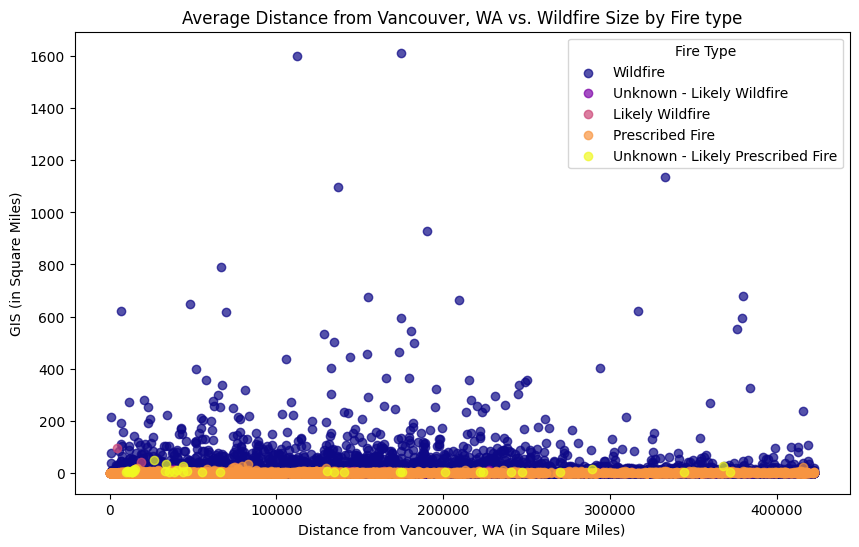

In [29]:
fire_types = wildfire_df['Assigned_Fire_Type'].unique()
colors = plt.cm.get_cmap('plasma', len(fire_types))

plt.figure(figsize=(10, 6))
for i, fire_type in enumerate(fire_types):
    subset = wildfire_df[wildfire_df['Assigned_Fire_Type'] == fire_type]
    plt.scatter(subset['average_distance_SqMiles'], 
                subset['GIS_SqMiles'], 
                color=colors(i), 
                label=fire_type, 
                alpha=0.7)

plt.xlabel('Distance from Vancouver, WA (in Square Miles)')
plt.ylabel('GIS (in Square Miles)')
plt.title('Average Distance from Vancouver, WA vs. Wildfire Size by Fire type')
plt.legend(title='Fire Type')
plt.show()

In [30]:
correlation, _ = spearmanr(wildfire_df['average_distance_SqMiles'], wildfire_df['GIS_SqMiles'])
print(f"Spearman correlation: {correlation}")

Spearman correlation: -0.05729146095500711


We don't see any particular trend here (Except maybe that only Fire Type = Wildfire are more in number and have larger area). They also don't seem to be very well correlated. It looks like most of the wildfires are small in size. They don't vary much with distance.

- I will try applying a log transformation visualize it better.
    - This will captures the non-linear effect. Both the area and distance are weighted now in a way that reflects their complex interactions.
    - Help reduce the impact of outliers.

I will add 1 to both `GIS_SqMiles` and `average_distance` to avoid the issue of taking the logarithm of small values.

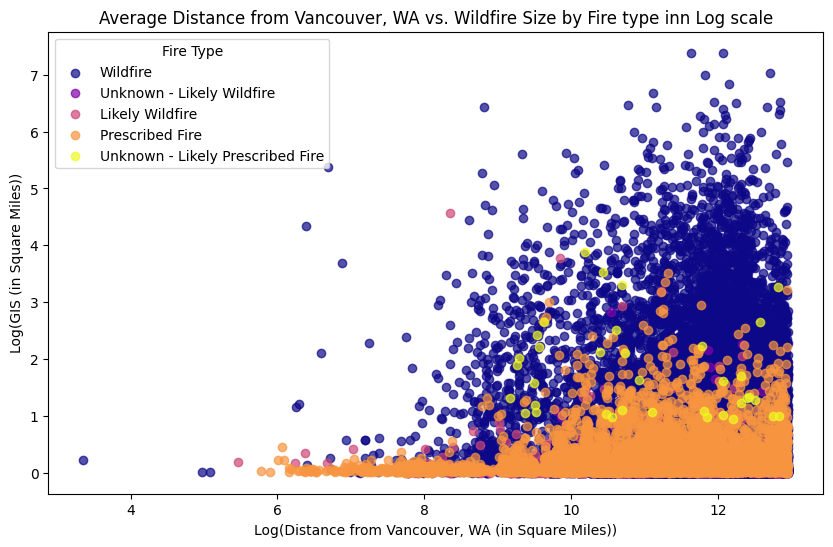

In [31]:
wildfire_df['log_average_distance'] = np.log(wildfire_df['average_distance_SqMiles'] + 1)
wildfire_df['log_GIS_SqMiles'] = np.log(wildfire_df['GIS_SqMiles'] + 1)

plt.figure(figsize=(10, 6))
for i, fire_type in enumerate(fire_types):
    subset = wildfire_df[wildfire_df['Assigned_Fire_Type'] == fire_type]
    plt.scatter(subset['log_average_distance'], 
                subset['log_GIS_SqMiles'], 
                color=colors(i), 
                label=fire_type, 
                alpha=0.7)

plt.xlabel('Log(Distance from Vancouver, WA (in Square Miles))')
plt.ylabel('Log(GIS (in Square Miles))')
plt.title('Average Distance from Vancouver, WA vs. Wildfire Size by Fire type inn Log scale')
plt.legend(title='Fire Type')
plt.show()

The plot appears to be left-skewed and not normally distributed; which means that log transformation is not appropriate in this scenario. Alternative transformations might be more appropriate.

I was also curious to check if it is the presence of outliers that is contributing to this skew in the log transformed dataset (i.e., I wanted to understand if all the fires "more in area" are being classified as outliers). To check that, I have a box plot below,

Text(0.5, 1.0, 'Box plot: Log Average Distance and Log Fire Size')

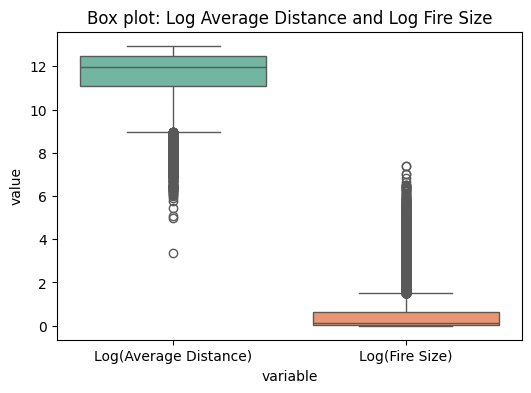

In [32]:
temp_boxplot = wildfire_df[['log_average_distance', 'log_GIS_SqMiles']]
temp_boxplot = temp_boxplot.melt()

plt.figure(figsize=(6, 4))
sns.boxplot(data=temp_boxplot, x='variable', y='value', palette='Set2')
plt.xticks([0, 1], ['Log(Average Distance)', 'Log(Fire Size)'])
plt.title("Box plot: Log Average Distance and Log Fire Size")

There are not many large wildfires compared to the ones small in size; hence, mostly they fall in the outliers category. The data is tightly clustered, resulting in a flat trend in the linear scale. 

A correlation of ~0 does not necessarily mean that the variables are independent. They might still have a non-linear relationship that is not captured by the correlation coefficient. However, for simplicity, **I am assuming that `GIS_SqMiles` and `average_distance` are independent of each other.**

The below equation,
```math
\text{GIS (SqMiles)} \times \frac{1}{\text{average distance}}
```
allows us to explore how the scale of a fire interacts with its distance from the point of interest (Vancouver, WA). By examining this combined effect, we can determine if larger fires significantly impact communities at different distances differently. 

As shown in the chart above and the heatmap, Fire Type seems to be positevely correlated to average distance. Let us now observe the same through a bar chart to see if there is a clear distinction.

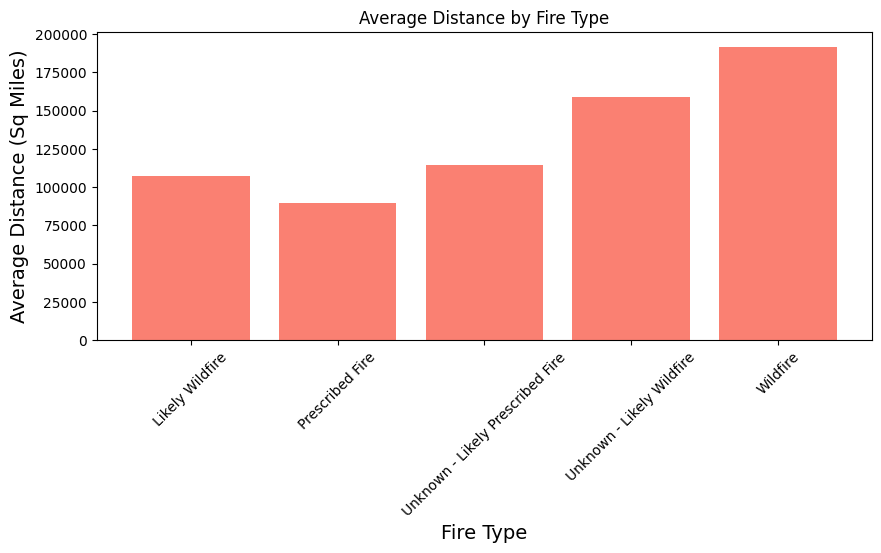

In [47]:
wildfire_df_by_type = wildfire_df.groupby('Assigned_Fire_Type')['average_distance_SqMiles'].mean().reset_index()

plt.figure(figsize=(10, 4))
plt.bar(wildfire_df_by_type ['Assigned_Fire_Type'], wildfire_df_by_type['average_distance_SqMiles'], color='salmon')
plt.xlabel('Fire Type', fontsize=14)
plt.ylabel('Average Distance (Sq Miles)', fontsize=14)
plt.title('Average Distance by Fire Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

There seems to be a clear distinction between the types and the average distance. Intuitively, it makes sense to give more importance to the wildfire and less importance to the Prescribed fire. We will thus use the mapping to scale the smoke estimation impact.

To model the smoke estimate accurately, we need to explore other factors influencing the wildfire size / average distance. However, since we don't have any in our dataset, we are intuitively modelling in this case.
- Extremely large wildfires are rare, but impactful. Distance also highly impacts the smoke emitted. 
    - The closer a wildfire is to Vancouver, WA, the more likely it is to impact the environment. Hence, `average_distance` is inversely proportional to the smoke estimate.
    - Larger the wildfire, greater its smoke impact. `GIS_SqMiles` is directly proportional to the smoke estimate.

Now we can assemble the components into a coherent formula for estimating smoke impact:

```math
\text{Smoke Estimate} = W \times c \times \text{GIS (SqMiles)} \times \frac{1}{\text{average distance}}
```

where,
- W: weight based on the fire type (`wildfire_df['Assigned_Fire_Type_Label']`)
- c: Constant of proportionality - Ideally should be determined from empirical observations as there could be factors based on specific environmental conditions that affect the smoke impact differently - For now, I am setting it to (1) since we don't any other information. 
- GIS (SqMiles): `wildfire_df['GIS_SqMiles']`
- average distance (SqMiles): `wildfire_df['average_distance']`

In [34]:
# Have a function to compute the smoke impact for each fire instance
def get_smoke_estimate(row):
    estimate = row['Assigned_Fire_Type_Label'] * row['GIS_SqMiles'] / row['average_distance']
    return estimate

# Apply get_smoke_estimate to each row
wildfire_df['smoke_estimate'] = wildfire_df.apply(get_smoke_estimate, axis=1)

wildfire_df.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,First_Listed_Fire_Dates,First_Listed_Fire_Month,Assigned_Fire_Type_Label,Listed_Fire_Cause_Class_cleaned,Listed_Fire_Cause_Class_cleaned_Label,GIS_SqMiles,average_distance_SqMiles,log_average_distance,log_GIS_SqMiles,smoke_estimate
0,13526,13526,Wildfire,1961,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,1961-09-08,9.0,1.0,Undetermined,0,86.327719,136428.671790,11.823565,4.469668,0.233721
2,13528,13528,Wildfire,1961,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,1961-09-02,9.0,1.0,Undetermined,0,53.490154,255956.270402,12.452766,3.998020,0.105728
3,13529,13529,Wildfire,1961,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,1961-07-12,7.0,1.0,Undetermined,0,51.353209,341119.884354,12.739992,3.958013,0.087925
4,13530,13530,Wildfire,1961,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,1961-09-01,9.0,1.0,Undetermined,0,42.607884,27843.853067,10.234403,3.775238,0.255344
7,13533,13533,Wildfire,1961,1,"1 (1), 3 (3)",13511.581889,5467.943194,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,1961-07-24,7.0,1.0,Undetermined,0,21.111847,147717.040721,11.903061,3.096114,0.054930


It looks like the value is very small. In the later steps as we need to compare the estmate with the Air Quality Index (AQI), let us scale the value by 1000.

In [58]:
wildfire_df['smoke_estimate_scaled'] = wildfire_df['smoke_estimate'] * 1000
wildfire_df.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,First_Listed_Fire_Month,Assigned_Fire_Type_Label,Listed_Fire_Cause_Class_cleaned,Listed_Fire_Cause_Class_cleaned_Label,GIS_SqMiles,average_distance_SqMiles,log_average_distance,log_GIS_SqMiles,smoke_estimate,smoke_estimate_scaled
0,13526,13526,Wildfire,1961,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,9.0,1.0,Undetermined,0,86.327719,136428.671790,11.823565,4.469668,0.233721,233.720841
2,13528,13528,Wildfire,1961,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,9.0,1.0,Undetermined,0,53.490154,255956.270402,12.452766,3.998020,0.105728,105.728230
3,13529,13529,Wildfire,1961,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,7.0,1.0,Undetermined,0,51.353209,341119.884354,12.739992,3.958013,0.087925,87.925342
4,13530,13530,Wildfire,1961,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,9.0,1.0,Undetermined,0,42.607884,27843.853067,10.234403,3.775238,0.255344,255.343792
7,13533,13533,Wildfire,1961,1,"1 (1), 3 (3)",13511.581889,5467.943194,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,7.0,1.0,Undetermined,0,21.111847,147717.040721,11.903061,3.096114,0.054930,54.930168


## 3. Save the Dataset grouped by date

In [59]:
wildfire_df.to_csv("../data/intermediate_data/wildfire_dataset_with_distance_and_smoke_estimate_by_date.csv")
print("Successfully saved the data!")

Successfully saved the data!


## 4. Saved the Dataset grouped by year

We are asked this question in the assignment:

"Should your smoke estimate be cumulative during each year or somehow amortized over the fire season? Document what goes into your decision making and what you did to create your smoke estimate."

- Cumulative estimates measure the total smoke emissions generated over a specific timeline, such as an entire fire season or a full calendar year. This approach totals all emissions without distributing them across that period.
    - Advantages:
        - Captures the overall impact of smoke on air quality.
        - Useful for long-term air quality assessments and regulatory compliance.
        - Offers insights into the total burden of smoke pollution over time.
    - Disadvantages:
        - May not accurately reflect short-term air quality fluctuations, as high emissions in peak fire periods can overshadow lower emissions during other times.

- Amortized estimates distribute smoke emissions evenly over a specified time frame, representing a more normalized impact per unit time (e.g., daily, monthly).
    - Advantages:
        - Provides a clearer picture of how smoke affects air quality on a day-to-day basis.
        - Facilitates better public health warnings and responses to smoke events.
        - Useful for managing chronic exposure risks from smoke over the season.
    - Disadvantages:
    - May downplay the significance of intense fire events that produce substantial smoke in a short period.

-  For comprehensive environmental studies, cumulative estimates can provide vital long-term trends, while for immediate air quality management and health impacts, amortized estimates can offer a more nuanced understanding of daily smoke exposure. For predicting the wildfire occurances for the next 25 years, we are looking to analyse the long-term trend. Hence, I am combining for year year.

In [65]:
# Group the dataframe by the fire year and find the total number of wildfires for each year
wildfire_count_by_year = wildfire_df.groupby(['Fire_Year'])['USGS_Assigned_ID'].count().reset_index()

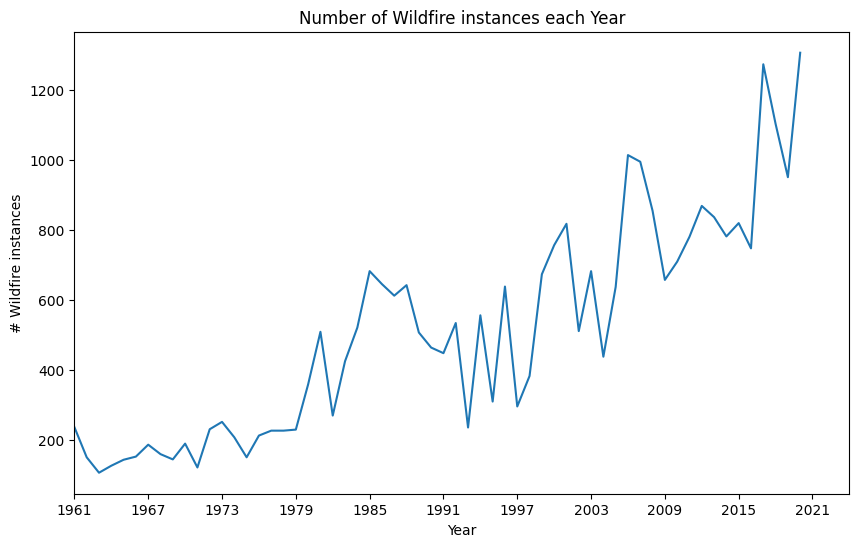

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(wildfire_count_by_year['Fire_Year'], wildfire_count_by_year['USGS_Assigned_ID'])
plt.xlabel('Year')
plt.ylabel('# Wildfire instances')
plt.title('Number of Wildfire instances each Year')
plt.xlim([1961, 2024]) 
plt.xticks(np.arange(1961, 2024, 6))
plt.show()

In [67]:
wildfire_df_by_year = wildfire_df.groupby('Fire_Year').agg({'smoke_estimate_scaled': 'mean', 
                                                            'GIS_SqMiles': 'mean', 
                                                            'average_distance': 'mean'}).reset_index()

wildfire_df_by_year.rename(columns={'Fire_Year': 'year', 
                                    'GIS_SqMiles': 'Mean_GIS_SqMiles', 
                                    'average_distance': 'Mean_average_distance'}, inplace=True)

wildfire_df_by_year.head()

,year,smoke_estimate_scaled,Mean_GIS_SqMiles,Mean_average_distance
0,1961,5.704264,2.112677,430.484837
1,1962,2.064932,0.839785,475.337610
2,1963,7.274286,2.346199,401.233279
3,1964,5.476086,2.354631,360.510278
4,1965,2.190371,0.954739,454.041410


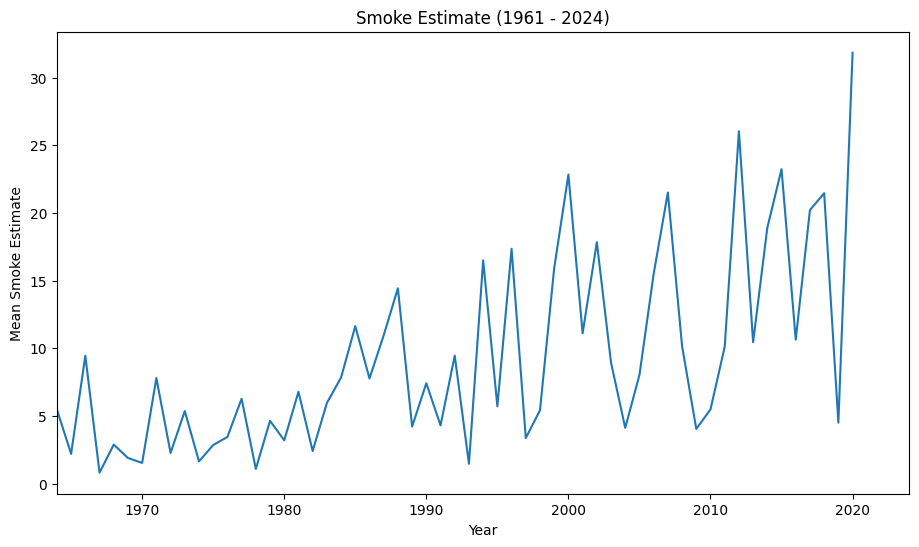

In [68]:
plt.figure(figsize=(11, 6))
plt.plot(wildfire_df_by_year['year'], wildfire_df_by_year['smoke_estimate_scaled'])
plt.xlabel('Year')
plt.ylabel('Mean Smoke Estimate')
plt.title('Smoke Estimate (1961 - 2024)')
plt.xlim([1964, 2024]) 
plt.show()

In [69]:
wildfire_df_by_year.to_csv("../data/intermediate_data/wildfire_dataset_with_distance_and_smoke_estimate_by_year.csv")
print("Successfully saved the data!")

Successfully saved the data!
